# Variational encoder model

## import lib


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init
import cudnn

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

import tqdm


## ML pipeline

### Step 0. Model Hyperparameters

In [100]:
# model hyperparameters
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 30
x_dim = 19
hidden_dim = 256
output_dim = 19

lr = 1.0e-4
epochs = 20



### Step 1. Load Dataset

get data from file

In [99]:
num_seeds = 30
training_seed = 21
seed = 0
# Load fullstate
data_fullstate = np.empty(num_seeds, dtype=object)
data_no_joint_pos = np.empty(num_seeds, dtype=object)
data_no_joint_vel = np.empty(num_seeds, dtype=object)
data_no_action = np.empty(num_seeds, dtype=object)
data_no_imu = np.empty(num_seeds, dtype=object)
data_no_fc = np.empty(num_seeds, dtype=object)
for i in range(num_seeds):
    data_fullstate[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-fullstate-rand-{i}.npz")    
    data_no_joint_pos[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_joint_pos-rand-{i}.npz")
    data_no_joint_vel[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_joint_vel-rand-{i}.npz")
    data_no_action[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_action-rand-{i}.npz")
    data_no_imu[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_imu-rand-{i}.npz")
    data_no_fc[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_fc-rand-{i}.npz")

In [101]:
all_state_dim = 64
all_action_dim = 19

state_dim = 64

train_x = torch.empty((0, all_state_dim), dtype=torch.float32 ,device=DEVICE)
train_y = torch.empty((0, all_action_dim), dtype=torch.float32,device=DEVICE)
test_x = torch.empty((0, all_state_dim), dtype=torch.float32,device=DEVICE)
test_y = torch.empty((0, all_action_dim), dtype=torch.float32,device=DEVICE)
for i in range(training_seed):
    train_x = torch.cat((train_x, torch.tensor(data_fullstate[i]["state"].reshape(data_fullstate[i]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    train_y = torch.cat((train_y, torch.tensor(data_fullstate[i]["action_lowpass"].reshape(data_fullstate[i]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
for j in range(training_seed, num_seeds):
    test_x = torch.cat((test_x, torch.tensor(data_no_joint_pos[j]["state"].reshape(data_no_joint_pos[j]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    test_y = torch.cat((test_y, torch.tensor(data_no_joint_pos[j]["action_lowpass"].reshape(data_no_joint_pos[j]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)

Converge to TensorDataset

In [102]:
state_index = torch.arange(0, 19)
action_index = torch.arange(0 , 19)
action_dim = output_dim
state_dim = len(state_index)

train_dataset = TensorDataset(train_x[:,state_index], train_y[:,action_index])
test_dataset = TensorDataset(test_x[:,state_index], test_y[:,action_index])

print("TRAIN : X , Y shape : ",train_x[:,state_index].shape , train_y.shape)
print("TEST : X , Y shape : ",test_x[:,state_index].shape , test_y.shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TRAIN : X , Y shape :  torch.Size([21000, 19]) torch.Size([21000, 19])
TEST : X , Y shape :  torch.Size([9000, 19]) torch.Size([9000, 19])


In [103]:
state_index = torch.arange(0, 19)
action_dim = output_dim
state_dim = len(state_index)

train_dataset = TensorDataset(train_x[:,state_index], train_y[:,action_index])
test_dataset = TensorDataset(test_x[:,state_index], test_y[:,action_index])

print("TRAIN : X , Y shape : ",train_x[:,state_index].shape , train_y.shape)
print("TEST : X , Y shape : ",test_x[:,state_index].shape , test_y.shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TRAIN : X , Y shape :  torch.Size([21000, 19]) torch.Size([21000, 19])
TEST : X , Y shape :  torch.Size([9000, 19]) torch.Size([9000, 19])


Explore some data

In [110]:
train_x[:, state_index].cpu().numpy()[:batch_size, 0].shape

(30,)

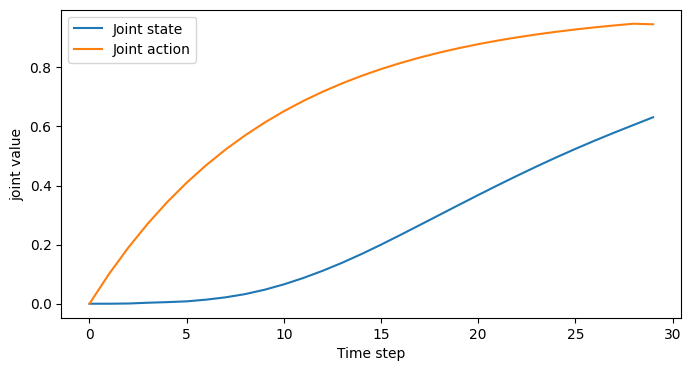

In [105]:
plt.figure(figsize=(8, 4))
plt.plot(train_x[:, state_index].cpu().numpy()[:batch_size, 0], label='Joint state')
plt.plot(train_y.cpu().numpy()[:batch_size, 0], label='Joint action')
plt.xlabel('Time step')
plt.ylabel('joint value')
plt.legend()

### Step 4. Training

In [111]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# ----- Model -----
class Predictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Predictor, self).__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output  = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.tanh(self.FC_input(x))
        h = self.tanh(self.FC_input2(h))
        out = self.FC_output(h)
        return out

# ----- Create Model -----
model = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr)

# ----- Training Loop -----
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(train_dataset)

    # ----- Evaluate -----
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            pred = model(x_batch)
            total_test_loss += criterion(pred, y_batch).item() * x_batch.size(0)
    avg_test_loss = total_test_loss / len(test_dataset)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f}")


<built-in method size of Tensor object at 0x00000231AF6E81E0>
Epoch 1/20 | Train Loss: 0.058963 | Test Loss: 0.470120
<built-in method size of Tensor object at 0x00000231AF6E8960>
Epoch 2/20 | Train Loss: 0.027112 | Test Loss: 0.553288
<built-in method size of Tensor object at 0x00000231AF6E8550>
Epoch 3/20 | Train Loss: 0.024563 | Test Loss: 0.603557
<built-in method size of Tensor object at 0x00000231AF6E8EB0>
Epoch 4/20 | Train Loss: 0.023293 | Test Loss: 0.637588
<built-in method size of Tensor object at 0x00000231AF6E8E60>
Epoch 5/20 | Train Loss: 0.022315 | Test Loss: 0.654278


KeyboardInterrupt: 

In [107]:
# ----- Evaluate -----
model.eval()
total_test_loss = 0.0
preds_list, targets_list = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        pred = model(x_batch)
        total_test_loss += criterion(pred, y_batch).item() * x_batch.size(0)

        preds_list.append(pred.cpu().numpy())
        targets_list.append(y_batch.cpu().numpy())

avg_test_loss = total_test_loss / len(test_dataset)

# Convert all predictions and targets
preds_all = np.vstack(preds_list)
targets_all = np.vstack(targets_list)

# ---- Metrics ----
mse = np.mean((preds_all - targets_all)**2, axis=0)           # per output
rmse = np.sqrt(mse)
mae = np.mean(np.abs(preds_all - targets_all), axis=0)
ss_res = np.sum((targets_all - preds_all) ** 2, axis=0)
ss_tot = np.sum((targets_all - np.mean(targets_all, axis=0)) ** 2, axis=0)
r2 = 1 - ss_res / ss_tot

print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f} | Test Loss (MSE): {avg_test_loss:.6f}")
print(f"  MAE per output:  {mae}")
print(f"  RMSE per output: {rmse}")
print(f"  R2 per output:   {r2}")

Epoch 20/20 | Train Loss: 0.016176 | Test Loss (MSE): 0.688321
  MAE per output:  [0.84350073 0.8935508  0.7950495  0.6796407  0.83454216 0.7746099
 0.7029417  0.41856918 0.66997105 0.21322262 0.47381455 0.68402267
 0.8436141  0.8479721  0.80414695 0.7101598  0.6153013  0.18681838
 0.7604641 ]
  RMSE per output: [1.013513   1.063739   0.95541096 0.8206594  0.9984086  0.9271928
 0.8168324  0.45498425 0.7897599  0.24935484 0.5297705  0.8207338
 1.0138011  0.9919545  0.96122265 0.851445   0.69387716 0.22865683
 0.8762039 ]
  R2 per output:   [-0.7016212  -0.86107445 -0.4521258  -1.351188   -1.1847751  -1.1286993
 -1.2816057  -2.722101   -1.7193091  -0.59228635 -3.8716145  -0.91713846
 -1.186831   -1.1762154  -1.6078577  -0.53538144 -0.39743018 -0.02374947
 -0.32160962]


In [108]:
idx = 8
print((model(test_x[idx , state_index])))
print((test_y[idx , state_index]))

tensor([ 0.5999,  0.5993,  0.5597, -0.7993, -0.6781,  0.3713,  0.6201, -0.1659,
        -0.4624, -0.3173, -0.2125,  0.5375,  0.5930, -0.4817, -0.5108, -0.5731,
        -0.3658,  0.5466, -0.4000], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([ 0.5695,  0.5032,  0.5652, -0.5613, -0.4884,  0.5435,  0.5483, -0.4384,
        -0.5652, -0.5477, -0.1636,  0.2945, -0.4256, -0.5695, -0.5695, -0.4389,
         0.4527,  0.5644, -0.2201], device='cuda:0')


In [109]:
idx = 9
print((model(train_x[idx , state_index])))
print((train_y[idx , state_index]))

tensor([ 0.4719,  0.4734,  0.4435, -0.4570, -0.4386,  0.3393,  0.4811, -0.1820,
        -0.4494, -0.3842, -0.1138,  0.2417,  0.3455, -0.3076, -0.4523, -0.4465,
        -0.0485,  0.2425, -0.3880], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([ 0.6126,  0.6125,  0.6128, -0.5997, -0.6120,  0.3453,  0.6025, -0.1968,
        -0.4524, -0.4091, -0.0757,  0.3082,  0.4745, -0.3563, -0.6127, -0.6114,
        -0.3848,  0.2544, -0.6108], device='cuda:0')
